# MSG-Net training

Based on: https://github.com/zhanghang1989/PyTorch-Multi-Style-Transfer

Dataset: https://cocodataset.org/#download
    
    Train - http://images.cocodataset.org/zips/train2014.zip

In [2]:
# Mount Google Drive for saving intermediate steps and trained model
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp -r "drive/MyDrive/msgnet/images/" "images/"

In [ ]:
# Download dataset
# !wget -P "//" "http://images.cocodataset.org/zips/train2014.zip"

In [ ]:
# !cp "/dataset/train2014.zip" "drive/MyDrive/msgnet/dataset/"

In [ ]:
%mkdir 'dataset/'
!unzip "/content/drive/MyDrive/msgnet/dataset/small_train.zip" -d "/dataset/"

In [ ]:
%mkdir "/content/drive/MyDrive/msgnet/models/"

In [4]:
import os
import sys
import time
import numpy as np
from tqdm import tqdm, trange

import torch
from torch.optim import Adam
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms

from PIL import Image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [5]:
# import numpy & pytorch
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable


# define Gram Matrix
class GramMatrix(nn.Module):
    def forward(self, y):
        (b, ch, h, w) = y.size()
        features = y.view(b, ch, w * h)
        features_t = features.transpose(1, 2)
        gram = features.bmm(features_t) / (ch * h * w)
        return gram


# proposed Inspiration(CoMatch) Layer
class Inspiration(nn.Module):
    """ Inspiration Layer (from MSG-Net paper)
    tuning the featuremap with target Gram Matrix
    ref https://arxiv.org/abs/1703.06953
    """
    def __init__(self, C, B=1):
        super(Inspiration, self).__init__()
        # B is equal to 1 or input mini_batch
        self.weight = nn.Parameter(torch.Tensor(1, C, C), requires_grad=True)
        # non-parameter buffer
        self.G = Variable(torch.Tensor(B, C, C), requires_grad=True)
        self.C = C
        self.reset_parameters()

    def reset_parameters(self):
        self.weight.data.uniform_(0.0, 0.02)

    def setTarget(self, target):
        self.G = target

    def forward(self, X):
        # input X is a 3D feature map
        self.P = torch.bmm(self.weight.expand_as(self.G), self.G)
        return torch.bmm(self.P.transpose(1, 2).expand(X.size(0), self.C, self.C),
                         X.view(X.size(0), X.size(1), -1)).view_as(X)

    def __repr__(self):
        return self.__class__.__name__ + '(' + 'N x ' + str(self.C) + ')'


# some basic layers, with reflectance padding
class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class UpsampleConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        if upsample:
            self.upsample_layer = torch.nn.Upsample(scale_factor=upsample)
        self.reflection_padding = kernel_size // 2
        if self.reflection_padding != 0:
            self.reflection_pad = nn.ReflectionPad2d(self.reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        if self.upsample:
            x = self.upsample_layer(x)
        if self.reflection_padding != 0:
            x = self.reflection_pad(x)
        out = self.conv2d(x)
        return out


class Bottleneck(nn.Module):
    """ Pre-activation residual block
    Identity Mapping in Deep Residual Networks
    ref https://arxiv.org/abs/1603.05027
    """
    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 norm_layer=nn.BatchNorm2d):
        super(Bottleneck, self).__init__()
        self.expansion = 4
        self.downsample = downsample
        if self.downsample is not None:
            self.residual_layer = nn.Conv2d(inplanes, planes*self.expansion,
                                            kernel_size=1, stride=stride)
        conv_block = []
        conv_block += [norm_layer(inplanes),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(inplanes, planes, kernel_size=1, stride=1)]
        conv_block += [norm_layer(planes),
                       nn.ReLU(inplace=True),
                       ConvLayer(planes, planes, kernel_size=3, stride=stride)]
        conv_block += [norm_layer(planes),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(planes, planes*self.expansion, kernel_size=1,
                                 stride=1)]
        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        if self.downsample is not None:
            residual = self.residual_layer(x)
        else:
            residual = x
        return residual + self.conv_block(x)


class UpBottleneck(nn.Module):
    """ Up-sample residual block (from MSG-Net paper)
    Enables passing identity all the way through the generator
    ref https://arxiv.org/abs/1703.06953
    """
    def __init__(self, inplanes, planes, stride=2, norm_layer=nn.BatchNorm2d):
        super(UpBottleneck, self).__init__()
        self.expansion = 4
        self.residual_layer = UpsampleConvLayer(inplanes, planes*self.expansion,
                                                kernel_size=1, stride=1,
                                                upsample=stride)
        conv_block = []
        conv_block += [norm_layer(inplanes),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(inplanes, planes, kernel_size=1, stride=1)]
        conv_block += [norm_layer(planes),
                       nn.ReLU(inplace=True),
                       UpsampleConvLayer(planes, planes, kernel_size=3,
                                         stride=1, upsample=stride)]
        conv_block += [norm_layer(planes),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(planes, planes*self.expansion, kernel_size=1,
                                 stride=1)]
        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return self.residual_layer(x) + self.conv_block(x)


class Vgg16(torch.nn.Module):
    def __init__(self):
        super(Vgg16, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

    def forward(self, X):
        h = F.relu(self.conv1_1(X))
        h = F.relu(self.conv1_2(h))
        relu1_2 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv2_1(h))
        h = F.relu(self.conv2_2(h))
        relu2_2 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv3_1(h))
        h = F.relu(self.conv3_2(h))
        h = F.relu(self.conv3_3(h))
        relu3_3 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv4_1(h))
        h = F.relu(self.conv4_2(h))
        h = F.relu(self.conv4_3(h))
        relu4_3 = h

        return [relu1_2, relu2_2, relu3_3, relu4_3]


# the MSG-Net
class Net(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, ngf=64,
                 norm_layer=nn.InstanceNorm2d, n_blocks=6, gpu_ids=[]):
        super(Net, self).__init__()
        self.gpu_ids = gpu_ids
        self.gram = GramMatrix()

        block = Bottleneck
        upblock = UpBottleneck
        expansion = 4

        model1 = []
        model1 += [ConvLayer(input_nc, 64, kernel_size=7, stride=1),
                   norm_layer(64),
                   nn.ReLU(inplace=True),
                   block(64, 32, 2, 1, norm_layer),
                   block(32*expansion, ngf, 2, 1, norm_layer)]
        self.model1 = nn.Sequential(*model1)

        model = []
        self.ins = Inspiration(ngf*expansion)
        model += [self.model1]
        model += [self.ins]

        for i in range(n_blocks):
            model += [block(ngf*expansion, ngf, 1, None, norm_layer)]

        model += [upblock(ngf*expansion, 32, 2, norm_layer),
                  upblock(32*expansion, 16, 2, norm_layer),
                  norm_layer(16*expansion),
                  nn.ReLU(inplace=True),
                  ConvLayer(16*expansion, output_nc, kernel_size=7, stride=1)]

        self.model = nn.Sequential(*model)

    def setTarget(self, Xs):
        f = self.model1(Xs)
        G = self.gram(f)
        self.ins.setTarget(G)

    def forward(self, input):
        return self.model(input)

In [6]:
from PIL import Image


def tensor_load_rgbimage(filename, size=None, scale=None, keep_asp=False):
    img = Image.open(filename).convert('RGB')
    if size is not None:
        if keep_asp:
            size2 = int(size * 1.0 / img.size[0] * img.size[1])
            img = img.resize((size, size2), Image.ANTIALIAS)
        else:
            img = img.resize((size, size), Image.ANTIALIAS)

    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)),
                         Image.ANTIALIAS)
    img = np.array(img).transpose(2, 0, 1)
    img = torch.from_numpy(img).float()
    return img


def tensor_save_rgbimage(tensor, filename, cuda=False):
    if cuda:
        img = tensor.clone().cpu().clamp(0, 255).numpy()
    else:
        img = tensor.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype('uint8')
    img = Image.fromarray(img)
    img.save(filename)


def tensor_save_bgrimage(tensor, filename, cuda=False):
    (b, g, r) = torch.chunk(tensor, 3)
    tensor = torch.cat((r, g, b))
    tensor_save_rgbimage(tensor, filename, cuda)


def preprocess_batch(batch):
    batch = batch.transpose(0, 1)
    (r, g, b) = torch.chunk(batch, 3)
    batch = torch.cat((b, g, r))
    batch = batch.transpose(0, 1)
    return batch

In [7]:
def init_vgg16(vgg16):
    torch_vgg16 = torchvision.models.vgg16( \
        weights=torchvision.models.VGG16_Weights.IMAGENET1K_FEATURES).features
    vgg16_list = list(vgg16.children())
    torch_vgg16_list = [x for x in list(vgg16.children()) if isinstance(x, nn.Conv2d)]

    for v, t in zip(vgg16_list, torch_vgg16_list):
        v.load_state_dict(t.state_dict())


class StyleLoader():
    def __init__(self, style_folder, style_size):
        self.folder = style_folder
        self.style_size = style_size
        self.files = os.listdir(style_folder)
    
    def get(self, i):
        idx = i%len(self.files)
        filepath = os.path.join(self.folder, self.files[idx])
        style = tensor_load_rgbimage(filepath, self.style_size)    
        style = style.unsqueeze(0)
        style = preprocess_batch(style)
        style = style.to(device)
        style_v = Variable(style, requires_grad=False)
        return style_v

    def size(self):
        return len(self.files)

In [8]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram


def subtract_imagenet_mean_batch(batch):
    """Subtract ImageNet mean pixel-wise from a BGR image."""
    tensortype = type(batch.data)
    mean = tensortype(batch.data.size()).to(device)
    mean[:, 0, :, :] = 103.939
    mean[:, 1, :, :] = 116.779
    mean[:, 2, :, :] = 123.680
    return batch - Variable(mean)


def add_imagenet_mean_batch(batch):
    """Add ImageNet mean pixel-wise from a BGR image."""
    tensortype = type(batch.data)
    mean = tensortype(batch.data.size()).to(device)
    mean[:, 0, :, :] = 103.939
    mean[:, 1, :, :] = 116.779
    mean[:, 2, :, :] = 123.680
    return batch + Variable(mean)

def imagenet_clamp_batch(batch, low, high):
    batch[:,0,:,:].data.clamp_(low-103.939, high-103.939)
    batch[:,1,:,:].data.clamp_(low-116.779, high-116.779)
    batch[:,2,:,:].data.clamp_(low-123.680, high-123.680)


In [ ]:
def train():
    seed = 42
    np.random.seed(seed)
    if device.type == 'cuda':
        torch.cuda.manual_seed(seed)
    else:
        torch.manual_seed(seed)

    image_size = 256
    dataset_path = '/dataset/'
    batch_size = 4

    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.CenterCrop(image_size),
                                    transforms.ToTensor(),
                                    transforms.Lambda(lambda x: x.mul(255))])
    train_dataset = datasets.ImageFolder(dataset_path, transform)
    train_loader = DataLoader(train_dataset, batch_size=4, num_workers=2)

    style_model = Net(ngf=128)

    # if args.resume is not None:
    #     print('Resuming, initializing using weight from {}.'.format(args.resume))
    #     style_model.load_state_dict(torch.load(args.resume))
    if True:
        resume_path = '/content/drive/MyDrive/msgnet/models/Final_epoch_4_Sat_Jan_28_21_39_00_2023_1_5.model'
        print('Resuming, initializing using weight from {}.'.format(resume_path))
        style_model.load_state_dict(torch.load(resume_path))

    # print(style_model)
    # optimizer = Adam(style_model.parameters(), lr=1e-3)
    optimizer = Adam(style_model.parameters(), lr=1e-4)
    mse_loss = torch.nn.MSELoss()

    vgg = Vgg16()
    # vgg_model_dir = 'models/'
    # init_vgg16(vgg_model_dir)
    # vgg.load_state_dict(torch.load(os.path.join(vgg_model_dir, "vgg16.weight")))
    init_vgg16(vgg)

    # if device == 'cuda':
    #     style_model.cuda()
    #     vgg.cuda()
    style_model = style_model.to(device)
    vgg = vgg.to(device)


    style_folder = "images/9styles/"
    style_size = 512
    style_loader = StyleLoader(style_folder, style_size)

    epochs = 2
    tbar = trange(epochs)
    for e in tbar:
        style_model.train()
        agg_content_loss = 0.
        agg_style_loss = 0.
        count = 0
        for batch_id, (x, _) in enumerate(train_loader):
            n_batch = len(x)
            count += n_batch
            optimizer.zero_grad()
            x = Variable(preprocess_batch(x))
            x = x.to(device)

            style_v = style_loader.get(batch_id)
            style_model.setTarget(style_v)

            style_v = subtract_imagenet_mean_batch(style_v)
            features_style = vgg(style_v)
            gram_style = [gram_matrix(y) for y in features_style]

            y = style_model(x)
            xc = Variable(x.data.clone())

            y = subtract_imagenet_mean_batch(y)
            xc = subtract_imagenet_mean_batch(xc)

            features_y = vgg(y)
            features_xc = vgg(xc)

            f_xc_c = Variable(features_xc[1].data, requires_grad=False)

            content_weight = 1
            content_loss = content_weight * mse_loss(features_y[1], f_xc_c)

            # print('1 start')
            # print(features_y[1].size())
            # print(f_xc_c.size())
            # print('1 end')
            # if not features_y[1].size() == f_xc_c.size(): return

            # style_weight = 5
            style_weight = 10
            style_loss = 0.
            for m in range(len(features_y)):
                gram_y = gram_matrix(features_y[m])
                # gram_s = Variable(gram_style[m].data, requires_grad=False).repeat(batch_size, 1, 1, 1)
                gram_s = Variable(gram_style[m].data, requires_grad=False).repeat(batch_size, 1, 1)
                style_loss += style_weight * mse_loss(gram_y, gram_s[:n_batch, :, :])

                # print('2 start')
                # print(gram_y.size())  # torch.Size([4, 64, 64])
                # print(Variable(gram_style[m].data, requires_grad=False).size())  # torch.Size([1, 64, 64])
                # print(gram_s.size())  # torch.Size([4, 1, 64, 64])
                # print(gram_s[:n_batch, :, :].size())  # torch.Size([4, 1, 64, 64])
                # print('2 end')
                # if not gram_y.size() == gram_s[:n_batch, :, :].size(): return
                # return  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                # The bug only generates warnings but doesn't do any harm)

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            agg_content_loss += content_loss.item()
            agg_style_loss += style_loss.item()

            log_interval = 500
            if (batch_id + 1) % log_interval == 0:
                mesg = "{}\tEpoch {}:\t[{}/{}]\tcontent: {:.6f}\tstyle: {:.6f}\ttotal: {:.6f}".format(
                    time.ctime(), e + 1, count, len(train_dataset),
                                agg_content_loss / (batch_id + 1),
                                agg_style_loss / (batch_id + 1),
                                (agg_content_loss + agg_style_loss) / (batch_id + 1)
                )
                tbar.set_description(mesg)

            
            if (batch_id + 1) % (4 * log_interval) == 0:
                # save model
                style_model.eval()
                style_model.cpu()
                save_model_filename = "Epoch_" + str(e) + "iters_" + str(count) + "_" + \
                    str(time.ctime()).replace(' ', '_') + "_" + str(
                    content_weight) + "_" + str(style_weight) + ".model"
                save_model_dir = "/content/drive/MyDrive/msgnet/models/"                
                save_model_path = os.path.join(save_model_dir, save_model_filename)
                torch.save(style_model.state_dict(), save_model_path)
                style_model.train()
                style_model.cuda()
                tbar.set_description("\nCheckpoint, trained model saved at", save_model_path)

    # save model
    style_model.eval()
    style_model.cpu()
    save_model_filename = "Final_epoch_" + str(epochs) + "_" + \
        str(time.ctime()).replace(' ', '_') + "_" + str(
        content_weight) + "_" + str(style_weight) + ".model"
    save_model_path = os.path.join(save_model_dir, save_model_filename)
    torch.save(style_model.state_dict(), save_model_path)

    print("\nDone, trained model saved at", save_model_path)

In [ ]:
#@title train

train()

Resuming, initializing using weight from /content/drive/MyDrive/msgnet/models/Final_epoch_4_Sat_Jan_28_21_39_00_2023_1_5.model.


Sat Jan 28 23:46:27 2023	Epoch 1:	[8000/40504]	content: 1.394852	style: 0.217820	total: 1.612672:   0%|          | 0/2 [17:33<?, ?it/s]
Sun Jan 29 00:04:02 2023	Epoch 1:	[16000/40504]	content: 1.397886	style: 0.202609	total: 1.600495:   0%|          | 0/2 [35:08<?, ?it/s]
Sun Jan 29 00:21:37 2023	Epoch 1:	[24000/40504]	content: 1.390040	style: 0.193942	total: 1.583982:   0%|          | 0/2 [52:43<?, ?it/s]
Sun Jan 29 00:39:11 2023	Epoch 1:	[32000/40504]	content: 1.385103	style: 0.189003	total: 1.574106:   0%|          | 0/2 [1:10:18<?, ?it/s]
Sun Jan 29 00:56:44 2023	Epoch 1:	[40000/40504]	content: 1.379689	style: 0.185112	total: 1.564801:   0%|          | 0/2 [1:27:50<?, ?it/s]
Checkpoint, trained model saved at:   0%|          | 0/2 [1:27:50<?, ?it/s]                                                              
Sun Jan 29 01:15:24 2023	Epoch 2:	[8000/40504]	content: 1.357875	style: 0.168671	total: 1.526546:  50%|█████     | 1/2 [1:46:30<1:28:57, 5337.10s/it]
Checkpoint, trained mode

In [ ]:
'/content/drive/MyDrive/msgnet/models/Final_epoch_4_Sat_Jan_28_21_39_00_2023_1_5.model'

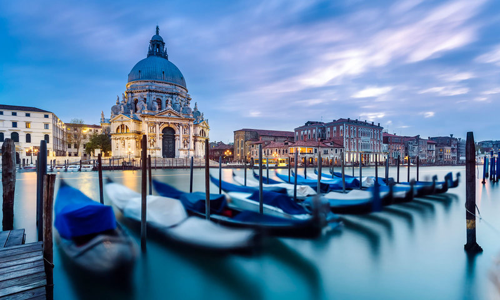

In [9]:
content_path = '/content/images/content/venice-boat.jpg'
display(Image.open(content_path).resize((500, 300)))

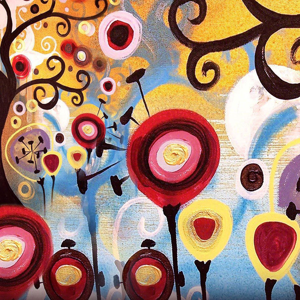

In [10]:
style_path = '/content/images/9styles/candy.jpg'
display(Image.open(style_path).resize((300, 300)))

In [11]:
content_image = tensor_load_rgbimage(content_path, size=512,
                                     keep_asp=True).unsqueeze(0)
style = tensor_load_rgbimage(style_path, size=512).unsqueeze(0)
style = preprocess_batch(style)

In [22]:
style_model = Net(ngf=128)
# model_dict = torch.load('/content/drive/MyDrive/msgnet/models/my.model')
model_dict = torch.load('/content/drive/MyDrive/msgnet/models/Epoch_1iters_24000_Sun_Jan_29_01:50:32_2023_1_10.model', map_location=torch.device('cpu'))
model_dict_clone = model_dict.copy()
for key, value in model_dict_clone.items():
    if key.endswith(('running_mean', 'running_var')):
        del model_dict[key]
style_model.load_state_dict(model_dict, False)

<All keys matched successfully>

In [14]:
def tensor_save_rgbimage(tensor, filename, cuda=False):
    if cuda:
        img = tensor.clone().cpu().clamp(0, 255).numpy()
    else:
        img = tensor.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype('uint8')
    img = Image.fromarray(img)
    img.save(filename)

def tensor_save_bgrimage(tensor, filename, cuda=False):
    (b, g, r) = torch.chunk(tensor, 3)
    tensor = torch.cat((r, g, b))
    tensor_save_rgbimage(tensor, filename, cuda)

In [23]:
style_v = Variable(style)
content_image = Variable(preprocess_batch(content_image))
style_model.setTarget(style_v)
output = style_model(content_image)
tensor_save_bgrimage(output.data[0], 'output.jpg', False)

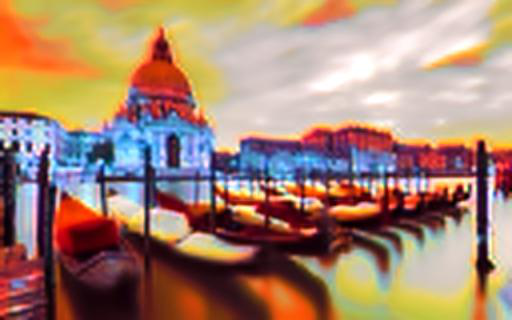

In [24]:
display(Image.open('output.jpg'))

Result from the original article

    https://github.com/zhanghang1989/PyTorch-Multi-Style-Transfer/blob/master/msgnet.ipynb

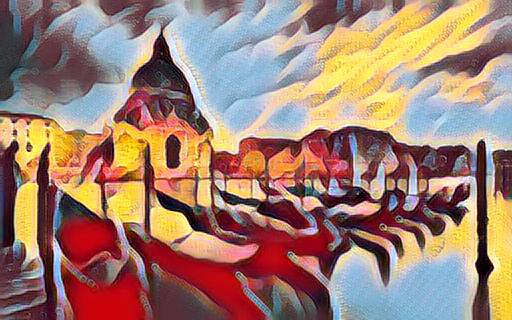

Such a difference might be because I trained my model on a smaller dataset and with only with 2 epochs (against 4 as was suggested - https://hangzhang.org/PyTorch-Encoding/tutorials/style.html#train-your-own-msg-net-model). Also, I loaded the Vgg16 model with standard weights from the pytorchvision package, and the author loaded some another one (pretrained lua-model of Vgg16). And of course it cannot be ruled out that I made mistakes when adapting the author's code)

In [25]:
from datetime import datetime

def inference(content_path, style_path):
    display(Image.open(content_path).resize((500, 300)))
    print()
    display(Image.open(style_path).resize((300, 300)))
    print()
    content_image = tensor_load_rgbimage(content_path, size=512,
                                     keep_asp=True).unsqueeze(0)
    style = tensor_load_rgbimage(style_path, size=512).unsqueeze(0)
    style = preprocess_batch(style)
    
    style_v = Variable(style)
    content_image = Variable(preprocess_batch(content_image))
    style_model.setTarget(style_v)
    output = style_model(content_image)
    output_path = f'output + {datetime.now()}.jpg'
    tensor_save_bgrimage(output.data[0], output_path, False)
    display(Image.open(output_path))

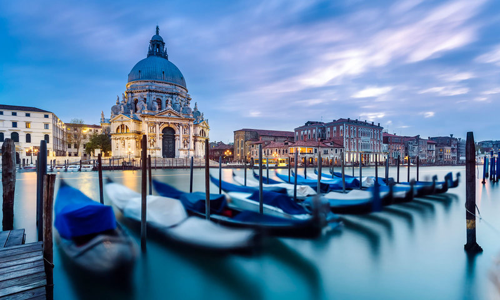

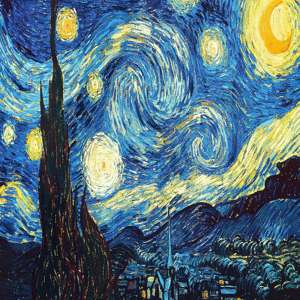

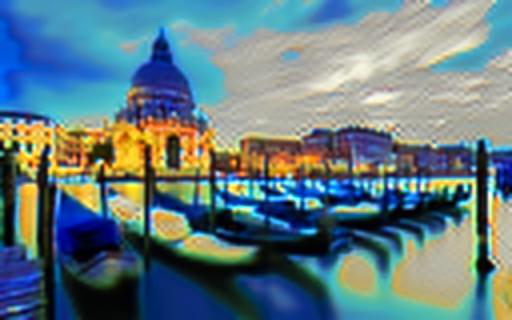

In [26]:
inference('/content/images/content/venice-boat.jpg', '/content/images/9styles/starry_night.jpg')

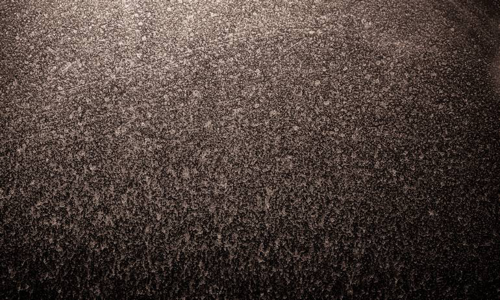

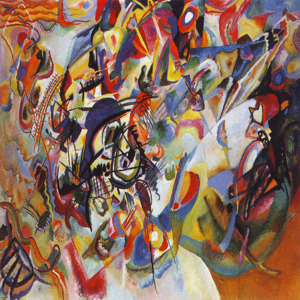

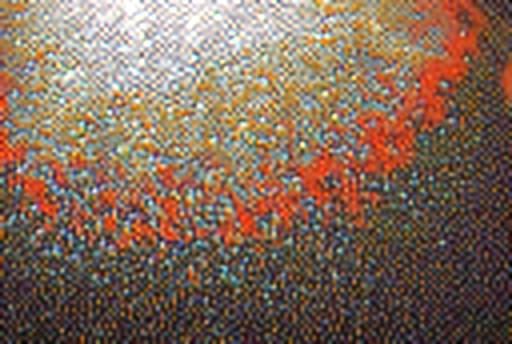

In [27]:
inference('/content/images/content/noise.jpg', '/content/images/9styles/composition_vii.jpg')

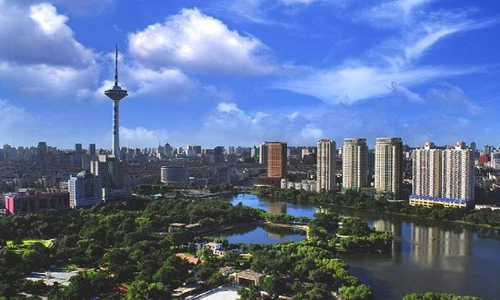

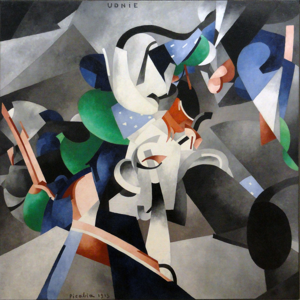

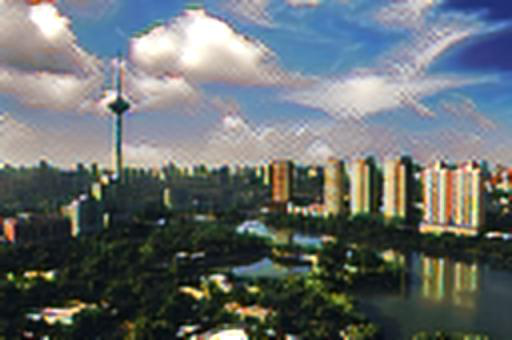

In [28]:
inference('/content/images/content/shenyang.jpg', '/content/images/9styles/udnie.jpg')

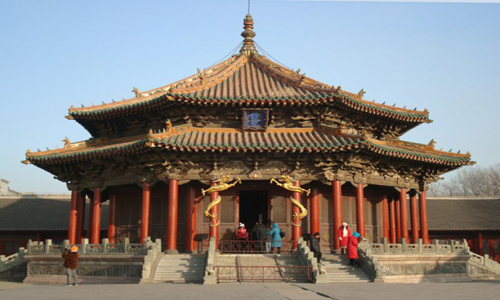

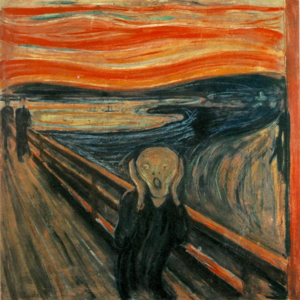

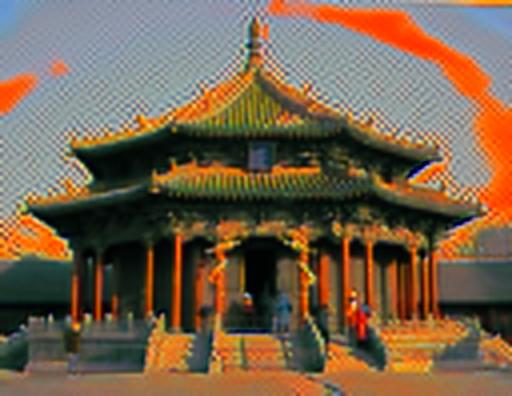

In [29]:
inference('/content/images/content/shenyang3.jpg', '/content/images/9styles/the_scream.jpg')